## H - Truncation and bounds

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 15 September 2023

**Proposal**: A simple example of truncated marginal neural ratio estimation (TMNRE).

**Key take-away messages**: Reducing data variance with truncation helps with simulation budgets and networks learning capacity.

### Code

In [1]:
import numpy as np
import pylab as plt
from scipy import stats
import swyft
import torch
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

Often we want to generate vectors whose components are drawn from different priors. This can be done with the `swyft.RectBoundSampler` object.  An example:

In [3]:
sampler = swyft.RectBoundSampler([stats.norm(0, 1),      # Standard normal prior
                                  stats.uniform(-1, 1),  # Uniform prior on the interval [-1, 0]
                                  stats.norm(5*np.ones(10), 0.01)  # 10 parameters 5 +- 0.01
                                  ])
sampler()  # Returns a 12-dim vector

array([ 1.12644856, -0.02138166,  5.00838619,  4.99903293,  5.00773982,
        4.98816343,  5.00358248,  4.98934626,  5.01595224,  5.00054793,
        4.99784431,  4.99370637])

This object provides convient functions to sample from truncated versions of the priors.  Those have to be specified as argument `bounds`.  Bounds should have the shape $N_\text{params} \times 2$.  An example:

In [4]:
bounds = np.array([[1., 1.1], [0.5, 0.6]])
sampler = swyft.RectBoundSampler([stats.norm(0, 1), stats.uniform(-1, 2)], bounds = bounds)
sampler()

array([1.04431981, 0.55684339])

We will use the simulator from the linear regression exercise above.  Instead of sampling with `np.random.rand`, we will however use the `RectBoundSampler`. We also will reduce the noise level.

In [5]:
class Simulator(swyft.Simulator):
    def __init__(self, Nbins = 100, sigma = 0.01, bounds = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.y = np.linspace(-1, 1, Nbins)
        self.sigma = sigma
        self.sample_z = swyft.RectBoundSampler(stats.uniform(np.array([-1, -1, -1]), np.array([2, 2, 2])), bounds = bounds)

    def calc_m(self, z):
        m = np.ones_like(self.y)*z[0] + self.y*z[1] + self.y**2*z[2]
        return m

    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.calc_m, z)
        x = graph.node('x', lambda m: m + np.random.randn(self.Nbins)*self.sigma, m)

We now generate a mock observation $\mathbf x_0 \sim p(\mathbf x| \mathbf z_0)$ with some simple parameter vector $\mathbf z_0 = (0, 0, 0)^T$. We contrast it with random draws from the simulator, $\mathbf x \sim p(\mathbf x)$.

  0%|          | 0/100 [00:00<?, ?it/s]

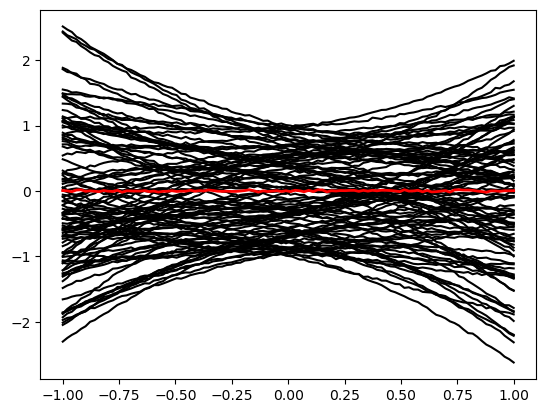

In [6]:
sim = Simulator()
obs = sim.sample(conditions = {'z': np.array([0, 0, 0])})
samples = sim.sample(100)
for i in range(len(samples)):
  plt.plot(sim.y, samples[i]['x'], 'k')
plt.plot(sim.y, obs['x'], 'r', lw=2)

Furthermore, we use again our standard inference network with linear compression.

In [7]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.lin = torch.nn.Linear(100, 10)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 10, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        f = self.lin(A['x'])
        logratios = self.logratios(f, B['z'])
        return logratios

We now define a function that performs a single "round" of simulation, training and evaluation.  As arguments, it only takes the `bounds` to use for the simulation, and the target `obs` for inference.

In [8]:
def round(obs, bounds = None):
    sim = Simulator(bounds = bounds)
    samples = sim.sample(10000)
    dm = swyft.SwyftDataModule(samples, batch_size = 64)
    trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)
    network = Network()
    trainer.fit(network, dm)
    prior_samples = sim.sample(N = 10000, targets = ['z'])
    predictions = trainer.infer(network, obs, prior_samples)
    new_bounds = swyft.collect_rect_bounds(predictions, 'z', (3,), threshold = 1e-6)
    return predictions, new_bounds, samples

The only new function is here `swyft.collect_rect_bounds`, which takes a collection of log ratio estimators as first argument, and then collects 1-dim bounds for the indicated parameter `z`.  The shape of z must be specified explicitly for the collection algorithm to work.

Now let's do three rounds of simulation, training, evaluation and bound determination. 

In [9]:
bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(3):
    predictions, bounds, samples = round(obs, bounds = bounds)
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

  0%|          | 0/10000 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | lin       | Linear                 | 1.0 K 
1 | logratios | LogRatioEstimator_1dim | 54.0 K


Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/cweniger/Documents/swyft/notebooks/lightning_logs/version_57/checkpoints/epoch=6-step=875.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 125it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


New bounds: tensor([[-1.0000,  0.0945],
        [-0.1555,  0.1479],
        [-0.1144,  0.1369]], dtype=torch.float64)


  0%|          | 0/10000 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | lin       | Linear                 | 1.0 K 
1 | logratios | LogRatioEstimator_1dim | 54.0 K
-----------------------------------------------------
55.0 K    Trainable params
0         Non-trainable params
55.0 K    Total params
0.440     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/cweniger/Documents/swyft/notebooks/lightning_logs/version_58/checkpoints/epoch=1-step=250.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 125it [00:00, ?it/s]

New bounds: tensor([[-0.7684,  0.0945],
        [-0.1555,  0.1478],
        [-0.1144,  0.1368]], dtype=torch.float64)


  0%|          | 0/10000 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | lin       | Linear                 | 1.0 K 
1 | logratios | LogRatioEstimator_1dim | 54.0 K
-----------------------------------------------------
55.0 K    Trainable params
0         Non-trainable params
55.0 K    Total params
0.440     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/cweniger/Documents/swyft/notebooks/lightning_logs/version_59/checkpoints/epoch=14-step=1875.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 125it [00:00, ?it/s]

New bounds: tensor([[-0.0386,  0.0337],
        [-0.0161,  0.0261],
        [-0.0700,  0.0590]], dtype=torch.float64)


Now we can plot the posteriors obtained in several subsequent rounds together. Initially they are wide, then they converge to narrow posteriors with high precision in the later rounds.

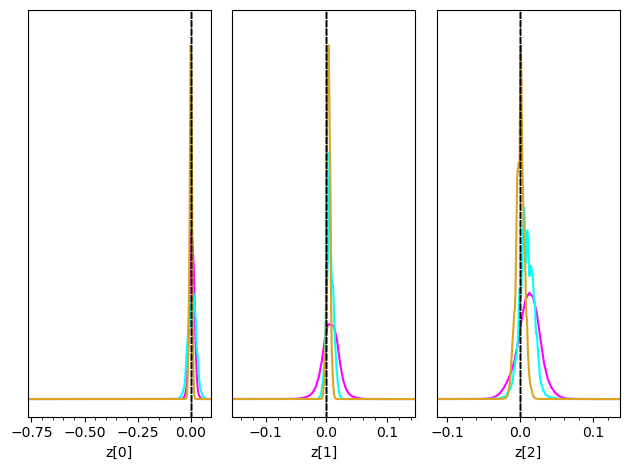

In [10]:
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(3)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(3)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

It is also instructive to plot the training data.

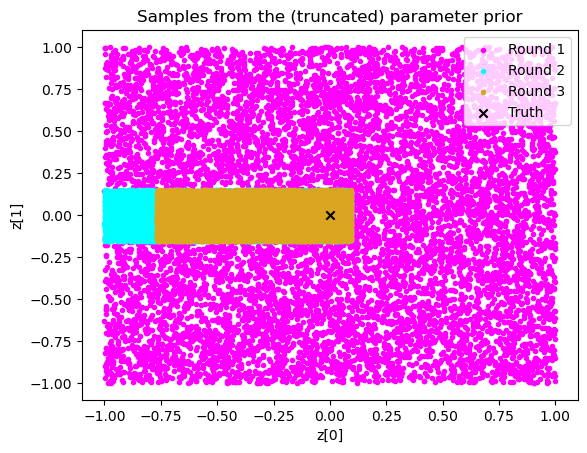

In [11]:
plt.scatter(samples_rounds[0]['z'][:,0], samples_rounds[0]['z'][:,1], color = 'fuchsia', label = 'Round 1', marker = '.')
plt.scatter(samples_rounds[1]['z'][:,0], samples_rounds[1]['z'][:,1], color = 'cyan', label = "Round 2", marker = '.')
plt.scatter(samples_rounds[2]['z'][:,0], samples_rounds[2]['z'][:,1], color = 'goldenrod', label = 'Round 3', marker = '.')
plt.scatter(obs['z'][0], obs['z'][1], marker = 'x', color='k', label = 'Truth')
plt.legend()
plt.xlabel("z[0]"); plt.ylabel("z[1]")
plt.title("Samples from the (truncated) parameter prior");

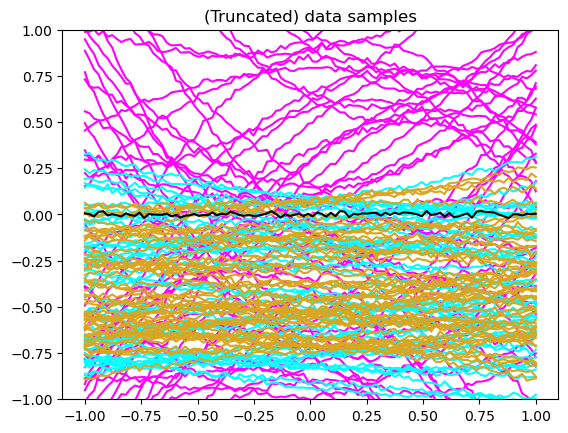

In [12]:
for i, color in enumerate(['fuchsia', 'cyan', 'goldenrod']):
    for j in range(50):
        plt.plot(sim.y, samples_rounds[i]['x'][j], color = color)
plt.plot(sim.y, obs['x'], color = 'k')
plt.ylim([-1, 1])
plt.title("(Truncated) data samples");

### Exercises

1. How many rounds are needed for convergence in this example?

In [13]:
# Results here

2. Lower the amount of training data per round to 3000.  Do you still achieve reasonable progress during subsequent rounds?

In [14]:
# Results here

3. What happens if you increase the threshold in the bound routine to 1e-2?

In [15]:
# Results here